In [31]:
# install package
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy
from IPython.display import clear_output

%matplotlib notebook

In [25]:
###### 画像 ######
path = "original1.png"
origin_img = cv2.imread(path)

###### 変数 ######
# コートサイズ設定
width = 1800 #コート横
height = 900 #コート縦

# コート四隅
cp_origin = [] #画像内座標配列
cp_trans = [[0,0], [0, height], [width, height], [width, 0]] #射影座標配列

# キャリブレーション物体
calib1 = [0, 0, 1] #キャリブレーション1画像内座標
calib2 = [0, 0, 1] #キャリブレーション2画像内座標

real_calib1 = [0, 0, 140] #既知キャリブレーション1世界座標
real_calib2 = [0, 900, 140] #既知キャリブレーション2世界座標

mode = "neutral" #処理モード管理変数

###### 関数 ######
def print_coord(): # 座標表示関数
    print("cp_origin", cp_origin)
    print("calib1", calib1)
    print("calib2", calib2)

def click_L(x, y): # 座標保存関数
    global cp_origin, calib1, calib2, mode
    if mode == "neutral":
        return
    elif mode == "calib1":
        calib1 = [x, y, 1]
    elif mode == "calib2":
        calib2 = [x, y, 1]
    else:
        cp_origin.append([x, y])
    print(x, y)

def click_R(): # 座標リセット関数
    global cp_origin, calib1, calib2, mode
    if mode == "neutral":
        return
    elif mode == "calib1":
        calib1 = [0, 0, 1]
    elif mode == "calib2":
        calib2 = [0, 0, 1]
    else:
        cp_origin = []
    print(mode, "reset")

def process(event, x, y, flags, params): # マウス割り当て関数
    if event == cv2.EVENT_LBUTTONDOWN:
        click_L(x, y)
    elif event == cv2.EVENT_RBUTTONDOWN:
        click_R()

###### クリック処理 ######
cv2.imshow("Calibration", origin_img)
cv2.setMouseCallback("Calibration", process)
while True:
    key = cv2.waitKey(0) & 0xff
    clear_output(True)
    if key == ord("a"):
        mode = "court"
    elif key == ord("b"):
        mode = "calib1"
    elif key == ord("c"):
        mode = "calib2"
    elif key == ord("z"):
        clear_output(True)
        break
    print(mode)
cv2.destroyAllWindows()

print_coord()

cp_origin [[637, 141], [26, 149], [114, 1046], [1220, 908]]
calib1 [642, 50, 1]
calib2 [22, 51, 1]


In [26]:
###### カメラ位置 ######
cp_origin = np.float32(cp_origin) # 型変換
cp_trans = np.float32(cp_trans) # 型変換
Matrix1 = cv2.getPerspectiveTransform(cp_origin, cp_trans) # 射影行列

# 射影先座標の計算
trans_calib1 = np.dot(Matrix1, calib1)
trans_calib2 = np.dot(Matrix1, calib2)
trans_calib1 /= trans_calib1[2]
trans_calib2 /= trans_calib2[2]
trans_calib1[2] = 0
trans_calib2[2] = 0

# ベクトルの定義
dir1 = real_calib1 - trans_calib1
dir2 = real_calib2 - trans_calib2

# 媒介変数
t = sympy.Symbol("t") # キャリブレーション1側
s = sympy.Symbol("s") # キャリブレーション2側

# XYZの差の二乗をとった距離関数
R = ((trans_calib1[0]+t*dir1[0]) - (trans_calib2[0]+s*dir2[0]))**2 + ((trans_calib1[1]+t*dir1[1]) - (trans_calib2[1]+s*dir2[1]))**2 + ((trans_calib1[2]+t*dir1[2]) - (trans_calib2[2]+s*dir2[2]))**2

# 偏微分
dR_dt = sympy.diff(R, t)
dR_ds = sympy.diff(R, s)

# 極値問題として解く（極大が存在しないため実質的に極小を求める）
ans = sympy.solve([dR_dt, dR_ds])
t_val = ans[t]
s_val = ans[s]

# 2直線上の最近点
close1 = np.float32([trans_calib1[0]+t_val*dir1[0], trans_calib1[1]+t_val*dir1[1], trans_calib1[2]+t_val*dir1[2]])
close2 = np.float32([trans_calib2[0]+s_val*dir2[0], trans_calib2[1]+s_val*dir2[1], trans_calib2[2]+s_val*dir2[2]])

# カメラ位置
camera1 = (close1+close2)/2
camera1

array([3182.9768,  963.0281, 1171.1602], dtype=float32)

<IPython.core.display.Javascript object>


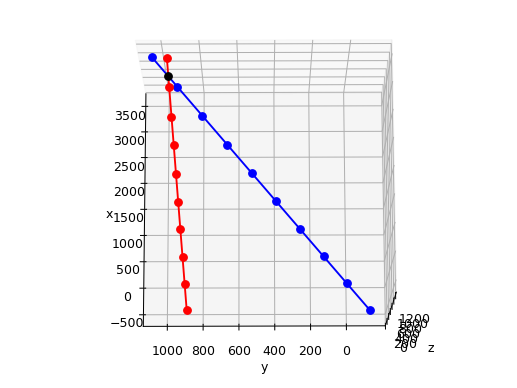

In [36]:
###### グラフ描画 ######
points = 10
# 直線1
line1_x = [trans_calib1[0]+i*dir1[0] for i in range(points)]
line1_y = [trans_calib1[1]+i*dir1[1] for i in range(points)]
line1_z = [trans_calib1[2]+i*dir1[2] for i in range(points)]
# 直線2
line2_x = [trans_calib2[0]+i*dir2[0] for i in range(points)]
line2_y = [trans_calib2[1]+i*dir2[1] for i in range(points)]
line2_z = [trans_calib2[2]+i*dir2[2] for i in range(points)]
# プロット
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot(line1_x, line1_y, line1_z, "o-", color="Blue")
ax.plot(line2_x, line2_y, line2_z, "o-", color="Red")
ax.plot(camera1[0], camera1[1], camera1[2], "-o", color="Black")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()